In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.3 MB/s eta 0:00:00


In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-09-06 05:45:35--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  4.13MB/s    in 0.8s    

2023-09-06 05:45:36 (4.13 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [ ]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier("This show was interesting")

[{'label': 'POSITIVE', 'score': 0.999747097492218}]

In [ ]:
classifier("This show was not bad at all")

[{'label': 'POSITIVE', 'score': 0.998742401599884}]

In [ ]:
classifier(["This course is just what I needed.",
             "I cant understand any of this . Instructor KEEPS TELING ME TO QUIT"])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9995642304420471}]

In [ ]:
#to get the GPU
import torch

In [ ]:
torch.cuda.is_available()

False

In [ ]:
df_ = pd.read_csv("AirlineTweets.csv")

In [ ]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df_[['airline_sentiment','text']].copy()

<Axes: >

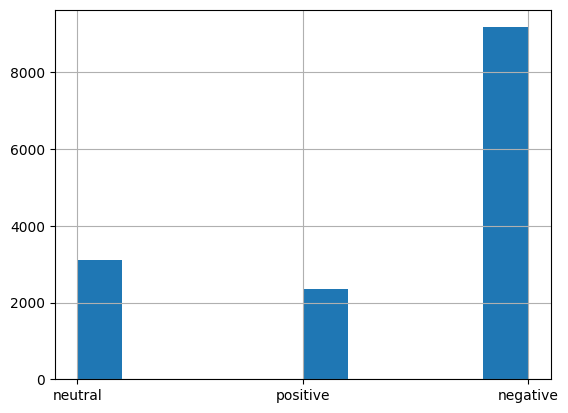

In [ ]:
df["airline_sentiment"].hist()

In [ ]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
df = df[df.airline_sentiment != "neutral"].copy()

In [ ]:
df.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
target_map = {"positive":1,"negative":0}

In [ ]:
df["target"]=df["airline_sentiment"].map(target_map)

In [ ]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [1]:
texts = df["text"].tolist()
predictions = classifier(texts)
print(predictions)

NameError: ignored

In [ ]:
probs = [d["score"] if d["label"].startswith("P") else 1-d["score"] for d in predictions]
print(probs)
preds = [1 if d["label"].startswith("P") else 0 for d in predictions]
preds = np.array(preds)

In [ ]:
cm = confusion_matrix(df["target"],preds,normalize=True)
cm